In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datasetZipFolder = "/content/drive/MyDrive/IOTDA Project/dataset"
datasetFolder = "/content/drive/MyDrive/IOTDA Project/dataset/"

**The following are some methods that we will use to parse the csv files**

In [ ]:
import numpy as np;


try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);



def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);
    
'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''

import gzip;

def read_user_data(uuid):
    user_data_file = datasetFolder + '%s.features_labels.csv.gz' % uuid;
  

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        csv_str = csv_str.decode("utf-8")
        pass;

    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

**Now we can read data for a particular user (make sure the user's data file is in this directory):**

In [ ]:
uuid = '9759096F-1119-4E19-A0AD-6F16989C7E1C';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);

The labels are provided with 'standardized' names, but we can prettify them:

In [ ]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [ ]:
n_examples_per_label = np.sum(Y,axis=0);
labels_and_counts = zip(label_names,n_examples_per_label);
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
print("How many examples does this user have for each contex-label:");
print("-"*20);
for (label,count) in sorted_labels_and_counts:
    print("label %s - %d minutes" % (get_label_pretty_name(label),count))
    pass;

How many examples does this user have for each contex-label:
--------------------
label Indoors - 4333 minutes
label Phone on table - 4031 minutes
label Lying down - 4022 minutes
label Sleeping - 3714 minutes
label Sitting - 2968 minutes
label With friends - 2572 minutes
label At home - 2219 minutes
label At school - 1341 minutes
label Computer work - 1201 minutes
label Phone in bag - 988 minutes
label Lab work - 982 minutes
label Standing - 659 minutes
label Phone in pocket - 620 minutes
label Eating - 322 minutes
label Walking - 218 minutes
label In a car - 157 minutes
label In a meeting - 131 minutes
label Bicycling - 109 minutes
label Exercise - 109 minutes
label Grooming - 17 minutes
label Dressing - 17 minutes
label Bathing - shower - 8 minutes
label Shopping - 7 minutes
label Cooking - 3 minutes
label Running - 0 minutes
label In class - 0 minutes
label At main workplace - 0 minutes
label Outside - 0 minutes
label On a bus - 0 minutes
label Drive - I'm the driver - 0 minutes
lab

**Let's do a differentiation between relaxed and stressed beheaviors.**

Our aim is to study and find differences between data coming from 2 different macro-groups of labels: labels identifying apparent relaxed behaviours (like 'Bicycling') and once identifying apparent stressed behaviours (like 'In a meeting').

In [ ]:
relaxed_labels = ['Lying down', 'Sleeping', 'With friends', 'Bicycling', 
                  'Exercise', 'Grooming', 'Bathing - shower', 'Shopping', 
                  'Running', 'Outside', 'At a restaurant', 'Strolling', 
                  'At a party', 'At the beach', 'At the gym']

In [ ]:
stressed_labels = ['Computer work', 'Lab work', 'In a meeting', 'In class', 
                   'At main workplace', 'On a bus', 'Drive - I\'m the driver', 
                   'Watching TV', 'Surfing the internet']

In [ ]:
other_labels = []

for label,count in (sorted_labels_and_counts):
  if get_label_pretty_name(label) not in relaxed_labels and get_label_pretty_name(label) not in stressed_labels: 
    other_labels.append(get_label_pretty_name(label))

print(other_labels)

['Indoors', 'Phone on table', 'Sitting', 'At home', 'At school', 'Phone in bag', 'Standing', 'Phone in pocket', 'Eating', 'Walking', 'In a car', 'Dressing', 'Cooking', "Drive - I'm a passenger", 'Drinking (alcohol)', 'Cleaning', 'Doing laundry', 'Washing dishes', 'At a bar', 'Singing', 'Talking', 'Toilet', 'Stairs - going up', 'Stairs - going down', 'Elevator', 'Phone in hand', 'With co-workers']


In [ ]:
relaxed_counter = 0
stressed_counter = 0
other_counter = 0

n_examples_per_label = np.sum(Y,axis=0);
labels_and_counts = zip(label_names,n_examples_per_label);
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
print("How many examples does this user have for each contex-label:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
  if(get_label_pretty_name(label) in relaxed_labels):
    print("[RELAXED] %s - %d minutes" % (get_label_pretty_name(label),count))
    relaxed_counter += count
  elif (get_label_pretty_name(label) in stressed_labels):
    print("[STRESSED] %s - %d minutes" % (get_label_pretty_name(label),count))
    stressed_counter+= count
  # else:
  #   print("[OTHER] %s - %d minutes" % (get_label_pretty_name(label),count))

How many examples does this user have for each contex-label:
--------------------
[RELAXED] Lying down - 4022 minutes
[RELAXED] Sleeping - 3714 minutes
[RELAXED] With friends - 2572 minutes
[STRESSED] Computer work - 1201 minutes
[STRESSED] Lab work - 982 minutes
[STRESSED] In a meeting - 131 minutes
[RELAXED] Bicycling - 109 minutes
[RELAXED] Exercise - 109 minutes
[RELAXED] Grooming - 17 minutes
[RELAXED] Bathing - shower - 8 minutes
[RELAXED] Shopping - 7 minutes
[RELAXED] Running - 0 minutes
[STRESSED] In class - 0 minutes
[STRESSED] At main workplace - 0 minutes
[RELAXED] Outside - 0 minutes
[STRESSED] On a bus - 0 minutes
[STRESSED] Drive - I'm the driver - 0 minutes
[RELAXED] At a restaurant - 0 minutes
[RELAXED] Strolling - 0 minutes
[STRESSED] Watching TV - 0 minutes
[STRESSED] Surfing the internet - 0 minutes
[RELAXED] At a party - 0 minutes
[RELAXED] At the beach - 0 minutes
[RELAXED] At the gym - 0 minutes


***TOTAL***
RELAXED: 10558 minutes
STRESSED: 2314 minutes


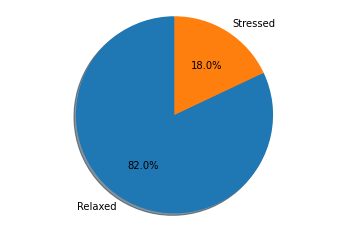

In [ ]:
print("***TOTAL***")
print("RELAXED: %d minutes" %relaxed_counter)
print("STRESSED: %d minutes" %stressed_counter)


import matplotlib.pyplot as plt 

labels = 'Relaxed', 'Stressed'
sizes = [relaxed_counter, stressed_counter]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can immediately notice that this user lives in a more relaxed way instead of stressing.

#**A MORE EXPANDED VIEW: ALL USER INVOLVED!**

Since our final goal is to detect the relaxed behaviours and the stressed ones, we are going to calculate the overall time spent doing each of those 2 behaviours by all the users involved in this study.

In [ ]:
import glob 
import os 

all_users = []

for user_file in glob.glob(os.path.join(datasetFolder, '*.csv.gz')):
      user_file = user_file.replace(datasetFolder, "")
      uuid = user_file.replace(".features_labels.csv.gz", "")
      # print(uuid)
      X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid);
      all_users.append(Y)

In [ ]:
relaxed_dictionary = {}
stressed_dictionary = {}

for label in relaxed_labels:
  relaxed_dictionary[label] = 0

for label in stressed_labels:
  stressed_dictionary[label] = 0


print(relaxed_dictionary)
print(stressed_dictionary)

{'Lying down': 0, 'Sleeping': 0, 'With friends': 0, 'Bicycling': 0, 'Exercise': 0, 'Grooming': 0, 'Bathing - shower': 0, 'Shopping': 0, 'Running': 0, 'Outside': 0, 'At a restaurant': 0, 'Strolling': 0, 'At a party': 0, 'At the beach': 0, 'At the gym': 0}
{'Computer work': 0, 'Lab work': 0, 'In a meeting': 0, 'In class': 0, 'At main workplace': 0, 'On a bus': 0, "Drive - I'm the driver": 0, 'Watching TV': 0, 'Surfing the internet': 0}


In [ ]:
for i in range (0, len(all_users)):
  n_examples_per_label = np.sum(all_users[i],axis=0);

  labels_and_counts = zip(label_names,n_examples_per_label);
  sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
  for (label,count) in sorted_labels_and_counts:
    label_pretty_name = get_label_pretty_name(label)
    if label_pretty_name in relaxed_dictionary:
      relaxed_dictionary[label_pretty_name] += count
    elif label_pretty_name in stressed_dictionary:
      stressed_dictionary[label_pretty_name] += count
    

print(relaxed_dictionary)
print(stressed_dictionary)

{'Lying down': 104210, 'Sleeping': 83055, 'With friends': 24737, 'Bicycling': 5020, 'Exercise': 8081, 'Grooming': 3064, 'Bathing - shower': 2087, 'Shopping': 1841, 'Running': 1090, 'Outside': 12114, 'At a restaurant': 2098, 'Strolling': 806, 'At a party': 1470, 'At the beach': 585, 'At the gym': 1151}
{'Computer work': 38081, 'Lab work': 3848, 'In a meeting': 5153, 'In class': 6110, 'At main workplace': 33944, 'On a bus': 1794, "Drive - I'm the driver": 7975, 'Watching TV': 13311, 'Surfing the internet': 19416}


In [ ]:
total_relaxed = 0
for label in relaxed_dictionary:
  total_relaxed += relaxed_dictionary[label]

total_stressed = 0
for label in stressed_dictionary:
  total_stressed += stressed_dictionary[label]

print(total_relaxed)
print(total_stressed)

251409
129632


***TOTAL***
RELAXED: 251409 minutes
STRESSED: 129632 minutes


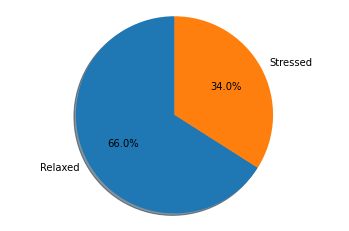

In [ ]:
print("***TOTAL***")
print("RELAXED: %d minutes" %total_relaxed)
print("STRESSED: %d minutes" %total_stressed)


import matplotlib.pyplot as plt 

labels = 'Relaxed', 'Stressed'
sizes = [total_relaxed, total_stressed]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As we can see all the users generally spend most of their time being relaxed instead of stressed, resulting in a better mental health.

#A MORE DETAILED VIEW


Let's see how the users spend their time performing specific activities that we grouped in static and movement categories.

In [ ]:
def get_counter_from(this_dictionary):
  sizes = []
  for label in this_dictionary:
    sizes.append(this_dictionary[label])

  return sizes

In [ ]:
relaxed_labels = list(relaxed_dictionary.keys())
relaxed_sizes = get_counter_from(relaxed_dictionary)

print(relaxed_labels)
print(relaxed_sizes)

['Lying down', 'Sleeping', 'With friends', 'Bicycling', 'Exercise', 'Grooming', 'Bathing - shower', 'Shopping', 'Running', 'Outside', 'At a restaurant', 'Strolling', 'At a party', 'At the beach', 'At the gym']
[104210, 83055, 24737, 5020, 8081, 3064, 2087, 1841, 1090, 12114, 2098, 806, 1470, 585, 1151]


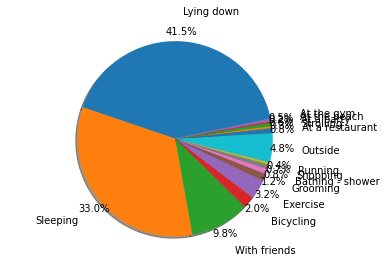

In [ ]:
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(relaxed_sizes, labels=relaxed_labels, autopct='%1.1f%%',
        shadow=True, pctdistance = 1.1, labeldistance = 1.3, startangle=12)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xticks(rotation='90')
plt.show()

**Lying down**  is the most common acitivty performed in the RELAXED group of labels. Let's move on with the stressed activities.

In [ ]:
stressed_labels = list(stressed_dictionary.keys())
stressed_sizes = get_counter_from(stressed_dictionary)

print(stressed_labels)
print(stressed_sizes)

['Computer work', 'Lab work', 'In a meeting', 'In class', 'At main workplace', 'On a bus', "Drive - I'm the driver", 'Watching TV', 'Surfing the internet']
[38081, 3848, 5153, 6110, 33944, 1794, 7975, 13311, 19416]


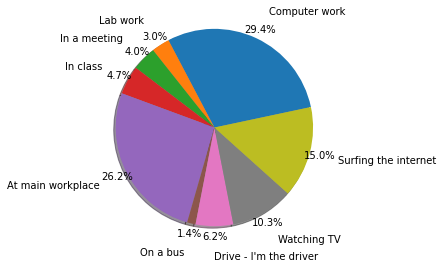

In [ ]:
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(stressed_sizes, labels=stressed_labels, autopct='%1.1f%%',
        shadow=True,pctdistance = 1.1, labeldistance = 1.3, startangle=12)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xticks(rotation='90')
plt.show()

**Computer work** is the most common activity performed in the STRESSED group labels.

# FIRST RECAP

We can see that, in the overall dataset, data referring to relaxed behaviours are predominant with respect to the other ones.

At this point, the work requires further investigations: we want to detect the most influential features that clearly differentiate a relaxed behaviour from a stressed one.

According to the studies conducted by Vaizman et al., there are different features that play a role as well: let's see them.

## Sensor features:
The features are less intuitive to interpret than the labels.
They were calculated from the fuller raw-measurements from the various sensors on the smartphone or smartwatch.

We can start by looking at the feature names, where the prefix of each feature indicates the sensor where it came from.
For convenience, we add a function to parse the feature names and provide the code-name of the sensor they belong to. We'll use the code-names as they appear in the original ExtraSensory paper:
Acc (phone-accelerometer), Gyro (phone-gyroscope), WAcc (watch-accelerometer), Loc (location), Aud (audio), and PS (phone-state).
Plus, the other sensors provided here that were not analyzed in the original paper: Magnet (phone-magnetometer), Compass 
(watch-compass), AP (audio properties, about the overall power of the audio), and LF (various low-frequency sensors).

In [ ]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;

In [ ]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


**VERY IMPORTANT**

We are going to use these indices to refer to the features.

In [ ]:
import pandas as pd

df_list=[]
for gzFile in os.listdir(datasetFolder):
  gzPath = datasetZipFolder+"//"+gzFile
  with gzip.open(gzPath) as f:
      df = pd.read_csv(f, header=0)
      df.insert(0,'uuid',gzFile[:-23])
      df_list.append(df)

df_dset = pd.concat(df_list, axis=0, ignore_index=True)
df_dset.head()

,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,...,label:IN_A_CAR,label:ON_A_BUS,label:DRIVE_-_I_M_THE_DRIVER,label:DRIVE_-_I_M_A_PASSENGER,label:LOC_home,label:FIX_restaurant,label:PHONE_IN_POCKET,label:OR_exercise,label:COOKING,label:SHOPPING,label:STROLLING,label:DRINKING__ALCOHOL_,label:BATHING_-_SHOWER,label:CLEANING,label:DOING_LAUNDRY,label:WASHING_DISHES,label:WATCHING_TV,label:SURFING_THE_INTERNET,label:AT_A_PARTY,label:AT_A_BAR,label:LOC_beach,label:SINGING,label:TALKING,label:COMPUTER_WORK,label:EATING,label:TOILET,label:GROOMING,label:DRESSING,label:AT_THE_GYM,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,0A986513-7828-4D53-AA1F-E02D6DF9561B,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,5.045157,0.000059,0.000231,0.000273,0.004710,0.430151,0.406215,0.253265,0.005318,0.000406,-1.000342,0.004052,0.003310,0.007697,-0.329743,0.382219,-0.121107,0.002536,0.002775,0.006024,0.010111,0.001327,0.001978,0.002784,0.689407,6.395739,4.578725,2.500818,3.515642,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,0A986513-7828-4D53-AA1F-E02D6DF9561B,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,5.044516,0.000063,0.000140,0.000142,0.003209,0.429944,0.173521,0.234487,0.006822,0.000355,-1.000211,0.002911,0.002960,0.003792,0.202860,0.335481,0.105470,0.002338,0.001546,0.002007,0.002750,0.001344,0.001968,0.002770,2.081808,6.505969,4.653110,2.209467,2.779620,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,0A986513-7828-4D53-AA1F-E02D6DF9561B,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,5.043892,0.000029,0.000084,0.000233,0.001885,0.429754,0.115731,0.163364,0.003077,-0.000170,-1.000802,0.002262,0.001760,0.002086,0.111225,0.488020,0.154312,0.002432,0.009142,0.027166,0.047330,0.001305,0.001823,0.002545,0.028810,6.016422,3.823204,3.596534,4.966467,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,0A986513-7828-4D53-AA1F-E02D6DF9561B,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,5.043505,0.000238,0.000878,0.000890,0.013964,0.429890,1.474943,0.121753,0.006925,0.002558,-1.001208,0.003094,0.003091,0.004724,-0.107052,0.351430,-0.05425

Let's consider data related to a single (randomly chosen) user:

In [ ]:
uuid = '9759096F-1119-4E19-A0AD-6F16989C7E1C';
user_data = df_dset.loc[df_dset['uuid']==uuid]
user_data = user_data.copy()
user_data.reset_index(inplace=True,drop=True)
print(user_data.shape)
user_data.head()

(9959, 279)


,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,...,label:IN_A_CAR,label:ON_A_BUS,label:DRIVE_-_I_M_THE_DRIVER,label:DRIVE_-_I_M_A_PASSENGER,label:LOC_home,label:FIX_restaurant,label:PHONE_IN_POCKET,label:OR_exercise,label:COOKING,label:SHOPPING,label:STROLLING,label:DRINKING__ALCOHOL_,label:BATHING_-_SHOWER,label:CLEANING,label:DOING_LAUNDRY,label:WASHING_DISHES,label:WATCHING_TV,label:SURFING_THE_INTERNET,label:AT_A_PARTY,label:AT_A_BAR,label:LOC_beach,label:SINGING,label:TALKING,label:COMPUTER_WORK,label:EATING,label:TOILET,label:GROOMING,label:DRESSING,label:AT_THE_GYM,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,9759096F-1119-4E19-A0AD-6F16989C7E1C,1441736514,1.003291,0.005195,0.004310,0.011728,1.001289,1.003300,1.005252,1.322772,6.684598,5.041996,0.000068,0.000171,0.000389,0.014363,0.429471,0.088975,0.139663,-0.000421,0.024209,-1.002986,0.003548,0.003596,0.005219,-0.152472,0.323705,0.248216,0.002803,0.003032,0.005659,0.008835,0.001499,0.002120,0.003130,1.046830,6.367916,5.467626,3.927958,4.049916,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2
1,9759096F-1119-4E19-A0AD-6F16989C7E1C,1441736574,1.002217,0.004838,-0.005512,0.011242,1.000948,1.002315,1.003754,1.208245,6.684600,5.043207,0.000039,0.000151,0.000420,0.003966,0.429616,0.317407,0.089067,0.014232,0.006549,-1.002074,0.003432,0.005435,0.004832,-0.047623,-0.408844,0.281432,0.003204,0.003285,0.005241,0.007398,0.001482,0.002396,0.003645,1.517679,6.356249,4.902354,3.670120,4.325034,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2
2,9759096F-1119-4E19-A0AD-6F16989C7E1C,1441736634,1.001739,0.002823,0.002405,0.005514,1.000531,1.001691,1.002908,1.561207,6.684608,5.043580,0.000134,0.000442,0.000646,0.006395,0.429768,0.115469,0.137183,0.013441,0.000062,-1.001640,0.002141,0.003505,0.002810,0.042538,-0.418176,0.180117,0.003387,0.003914,0.006266,0.008756,0.001531,0.002225,0.003453,1.494933,6.290452,5.508334,3.674177,5.100242,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2
3,9759096F-1119-4E19-A0AD-6F16989C7E1C,1441736694,1.001726,0.005243,-0.004414,0.011420,1.000125,1.001865,1.003400,1.345673,6.684598,5.043709,0.000043,0.000208,0.000266,0.012912,0.429897,0.086749,0.231530,0.009496,0.008513,-1.001628,0.003632,0.004500,0.005238,0.337289,-0.478570,-0.141964,0

### Knowing this, let's consider some potentially important features that must be useful to detect different behaviours and let's see how they vary overtime, performing a specific kind of activity.

To start let's define a function that takes as input 2 LABELS (which we want to compare) and the feauture's index that we want to analyze (the feature index is taken from the list of features above)

In [ ]:
import math
from matplotlib.ticker import FormatStrFormatter


def extract_data_and_graph(first_label,second_label, feature_index):
  
  user_data_lying = user_data.loc[user_data["label:"+first_label]==1].copy()
  timestamps_lying = user_data_lying['timestamp']
  user_data_computer = user_data.loc[user_data["label:"+second_label]==1].copy()
  timestamps_computer = user_data_computer['timestamp']
  
  feat_values_lying = user_data_lying.iloc[:,feature_index+2:feature_index+3]
  feat_values_computer = user_data_computer.iloc[:,feature_index+2:feature_index+3]

  feat_values_lying = feat_values_lying[~np.isnan(feat_values_lying)]
  feat_values_lying = feat_values_lying[feat_values_lying>0]

  feat_values_computer = feat_values_computer[~np.isnan(feat_values_computer)]
  feat_values_computer = feat_values_computer[feat_values_computer>0]

  # seconds_in_day = (60*60*24);
  days_since_participation_2= (timestamps_computer - timestamps_computer.iloc[0]) / float(60*60*24);
  print('')
  days_since_participation = (timestamps_lying - timestamps_lying.iloc[0]) / float(60*60*24);
  # print(days_since_participation)
  # print(days_since_participation_2)

  
  lastXValue = (int(max(days_since_participation.iloc[-1],days_since_participation_2.iloc[-1])))
  maxYValue = (max(float(feat_values_computer.max()), float(feat_values_lying.max())))
  minYValue = (min(float(feat_values_computer.min()), float(feat_values_lying.min())))
  # print(maxYValue)
  # print(minYValue)
  # print(truncate(maxYValue, 4))
  # print(math.floor(minYValue))
  # print(math.ceil(maxYValue))

  fig = plt.figure(figsize=(25,6));

  ax1 = plt.subplot(1,2,1);

  ax1.plot(days_since_participation, feat_values_lying, 'ro');
  plt.ylabel(first_label + "  VALUES");
  plt.xlabel('days');
  plt.xticks(range(0,lastXValue+1))
  plt.xlim(-1, lastXValue+1) 
  ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # plt.yticks(range(minYValue, maxYValue))
  # print(minYValue, maxYValue)
  if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
    plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)
  # print(minYValue, maxYValue)


  # plt.title('%d) %s\nfunction of time' % (ind,feature));

  ax1 = plt.subplot(1,2,2);
  ax1.plot(days_since_participation_2,feat_values_computer, 'ro');
  plt.ylabel(second_label+"  VALUES");
  plt.xlabel('days');
  plt.xticks(range(0,lastXValue+1))
  plt.xlim(-1, lastXValue+1)
  ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # plt.yticks(range(minYValue, maxYValue))
  if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
    plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)




  fig = plt.figure(figsize=(10,6));

  ax3 = plt.subplot(1,1,1);
  plt.autoscale()
  to_boxplot1 = feat_values_lying[feat_values_lying.columns[0]].values
  to_boxplot2 = feat_values_computer[feat_values_computer.columns[0]].values
  # print(to_boxplot1.shape)
  to_boxplot1 = to_boxplot1[~np.isnan(to_boxplot1)]
  to_boxplot2 = to_boxplot2[~np.isnan(to_boxplot2)]

  ax3.boxplot([to_boxplot1, to_boxplot2], labels = [first_label, second_label])
  plt.autoscale()
  # # plt.title('%d) %s\nhistogram' % (ind,feature));

Let's compare the value distribution of the latitude between the data labeled as LYING_DOWN and the data labeled as COMPUTER_WORK of this user (why these 2 labels? Because they are the most common activities performed by the users of this work)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


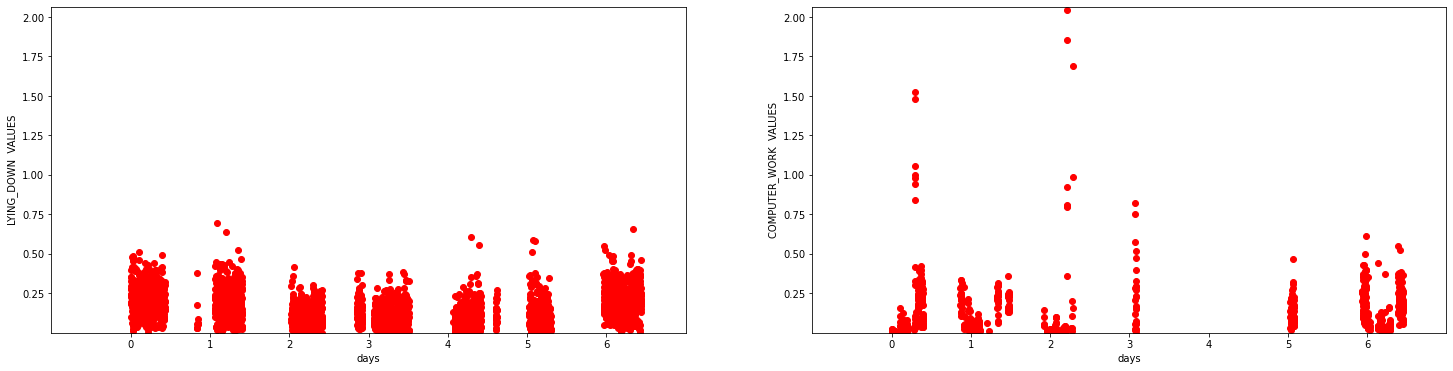

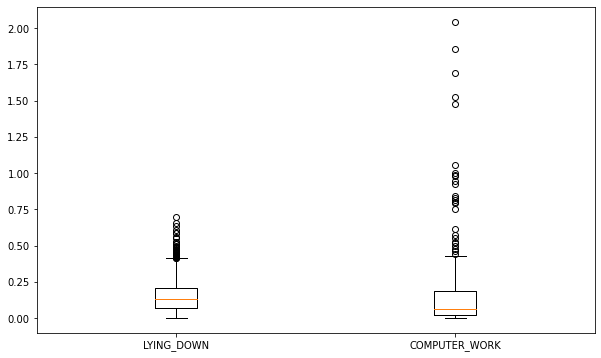

In [ ]:
#location:log_latitude_range : its index is 139
extract_data_and_graph("LYING_DOWN", "COMPUTER_WORK", feature_index = 139)

**[1ST and 2 GRAPH] DURING THE LYING_DOWN EVENTS, the values are more NUMEROUS than the COMPUTER_WORK ONES: this is maybe because this user typycally remember to use the ExtraSensory app to describe their activity while they are lying down, instead for the COMPUTER_WORK EVENTS they sometimes forget to do the labeling activity, probably because they are busy.**

**[BOXPLOTS] We can also say that the COMPUTER_WORK VALUES are more SCATTERED and HIGHER with respect to the LYING_DOWN VALUES: the majority of LYING_DOWN VALUES (the box, that contains the central 50% of the observations made) is all concentrated between 0.00 and 0.25, while the box of COMPUTER_WORK VALUES appears to be bigger and concentrated between 0.00 and 0.25 as well.**

**The two lines that extend from the box are called "whiskers" and indicate variability outside the upper and lower quartiles. Outliers that differ significantly from the rest of the dataset are plotted as individual points beyond the whiskers on the box-plot. The whiskers of the two events seem to have the same height and for both events we notice the presence of OUTLIERS. The outliers of LYING_DOWN event appear to be more concentrated than the ones of COMPUTER_WORK event, which are more scattered. **

Now let's compare the longitude between the same labeled data (LYING_DOWN and COMPUTER_WORK)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


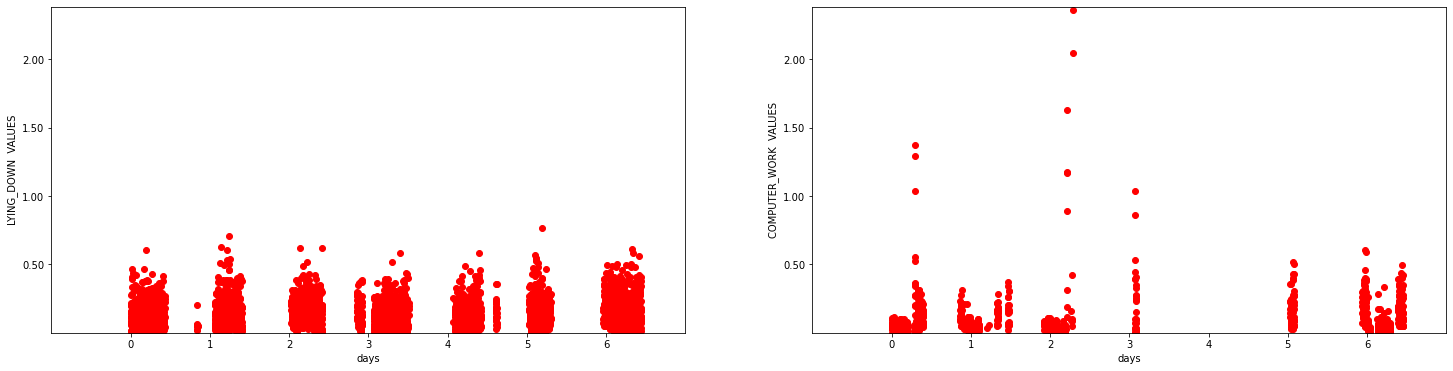

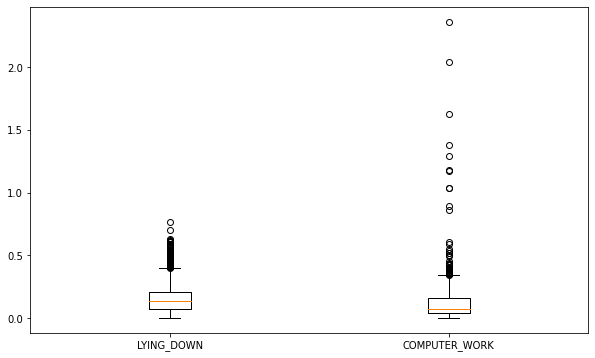

In [ ]:
#location:log_longitude_range : its index is 140
extract_data_and_graph("LYING_DOWN", "COMPUTER_WORK", feature_index = 140)

Same behavior!

**Different feature, but almost the same behaviour: COMPUTER_WORK VALUES MORE SCATTERED, LESS in quantity but HIGHER in value.**

NOw, let's compare the audio values: keep in mind that, related to the audio feature, we have 13 different columns, each of those describing a MFFC coefficient.

The Mel-Frequency Cepstract coefficients describe some caratheristics related to the audio recorded. Here we have 13 coefficients because usually 12-13 coefficients keep the most relevant information.

Nowe let's compare the maximum absolute value of the audio!

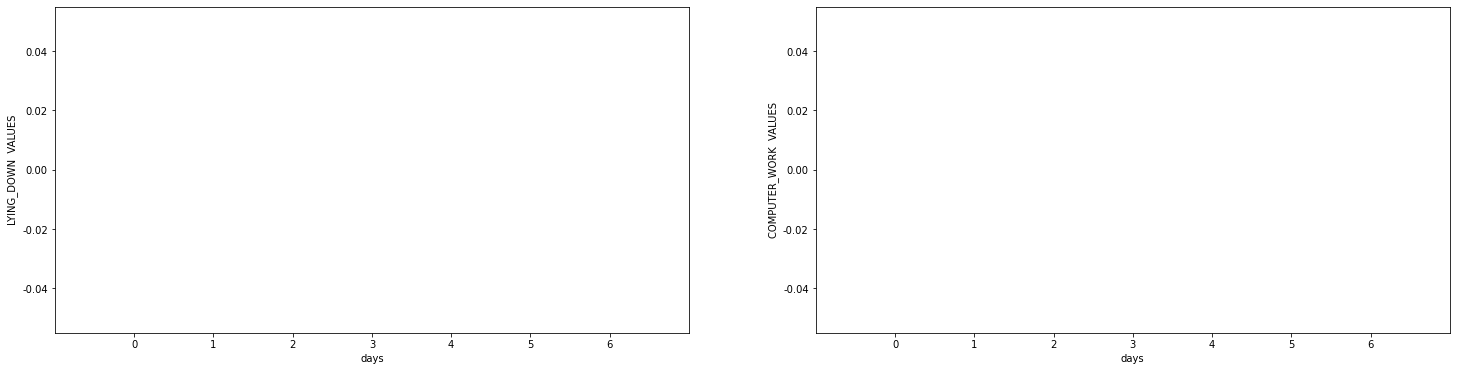

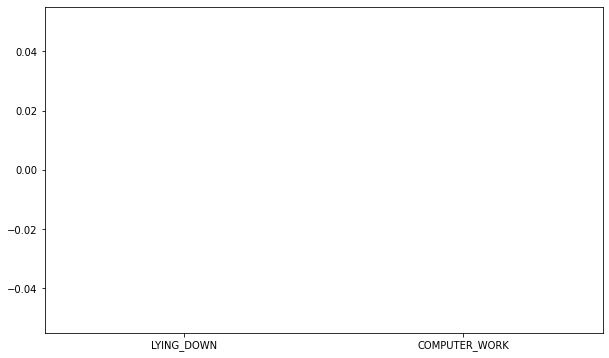

In [ ]:
# audio_properties:max_abs_value: its index is 181
extract_data_and_graph("LYING_DOWN", "COMPUTER_WORK", feature_index = 181)

For this user it appears we have no data available for the audio: in order to have a more significant analysis, we will analyze data of more than one user, with more that 2 labels mentioned as examples up to now.

Now let's see what happens with the battery indicatory of the user's phone: a feature that in our opinion can be important since it can be useful to identify a COMPUTER_WORK behavior from a LYING_DOWN one. This hypothesys comes from the assumption that when the user is at the computer, they are probably not using their phone. At home it's reasonable that he just charged the phone, or he's charging it in the right moment that he's performing the labeling activity on the Extrasensory app.

**And so the battery level during LYING_DOWN events can be HIGHER with respect to the battery level during COMPUTER_WORK events.**

Let's see if the plot is telling us something useful

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


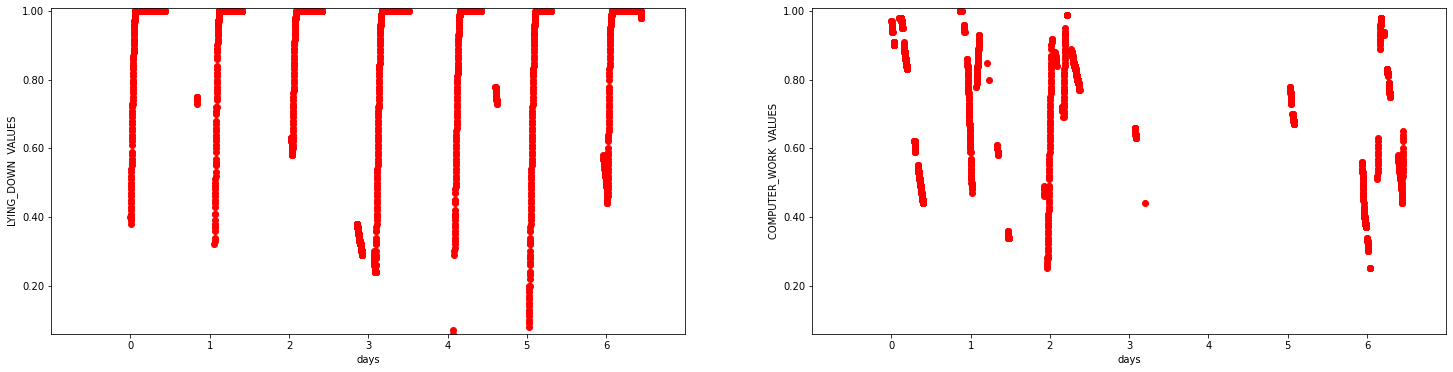

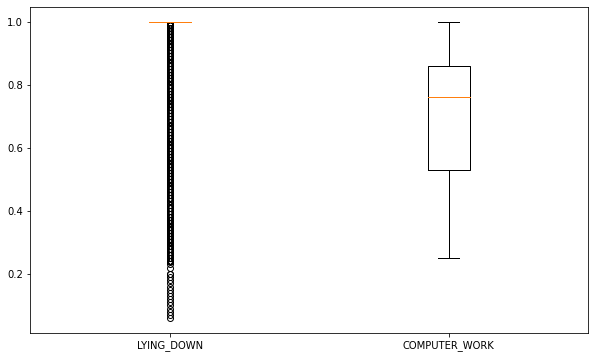

In [ ]:
# lf_measurements:battery_level: its index is 214
extract_data_and_graph("LYING_DOWN", "COMPUTER_WORK", feature_index = 214)

As we can see there are more values for LYING_DOWN instead of COMPUTER_WORK. The boxplots appears to have a lot of outliers for the LYING_DOWN event.

Finally, let's see what happens with the phone state feature called "brightness". This feature means that the user is using the phone when the value is 1 and they are not using it when the value is 0. This feature can be useful to identify when the phone is used, which an intense use of smartphone is correlated with the level of stress.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


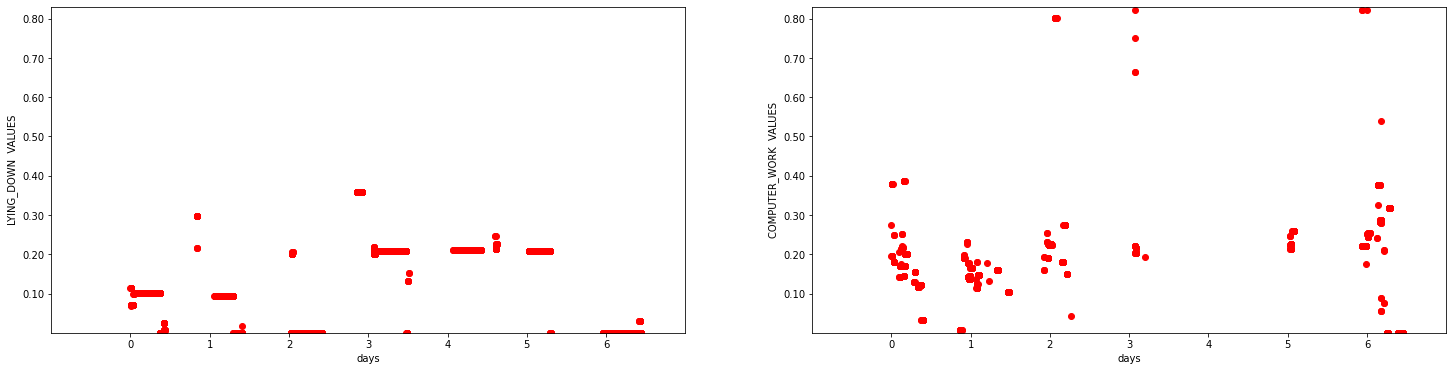

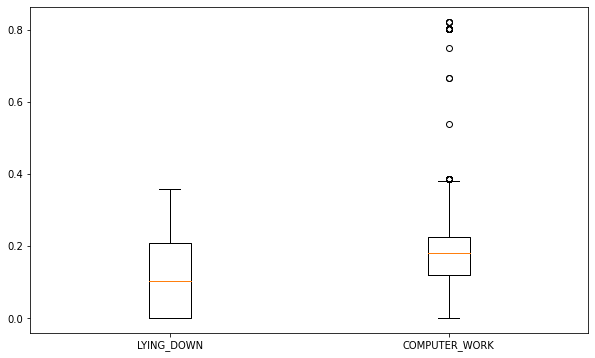

In [ ]:
# lf_measurements:screen_brightness: its index is 215
extract_data_and_graph("LYING_DOWN", "COMPUTER_WORK", feature_index = 215)

There are always more values for the LYING_DOWN event and the boxplot of the LYING_DOWN data is concentrated around values generally lower than COMPUTER_WORK ones.

#2nd study

As first study we conducted this brief analysis regarding data of a single user, taking into consideration only the most important label of the 2 macrogroups of labels that we create: LYING DOWN for the RELAXED group, COMPUTER WORK for the STRESSED one.

To have a more precise view of the data, let's go to expand this analysis: we are going to take into consideration ALL THE USERS and ALL THE LABELS of the 2 macrogrups, making a comparison between them.


In [ ]:
for user_file in glob.glob(os.path.join(datasetFolder, '*.csv.gz')):
      user_file = user_file.replace(datasetFolder, "")
      uuid = user_file.replace(".features_labels.csv.gz", "")
      print(uuid)

0A986513-7828-4D53-AA1F-E02D6DF9561B
00EABED2-271D-49D8-B599-1D4A09240601
098A72A5-E3E5-4F54-A152-BBDA0DF7B694
1155FF54-63D3-4AB2-9863-8385D0BD0A13
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842
0BFC35E2-4817-4865-BFA7-764742302A2D
24E40C4C-A349-4F9F-93AB-01D00FB994AF
1538C99F-BA1E-4EFB-A949-6C7C47701B20
0E6184E1-90C0-48EE-B25A-F1ECB7B9714E
11B5EC4D-4133-4289-B475-4E737182A406
136562B6-95B2-483D-88DC-065F28409FD2
481F4DD2-7689-43B9-A2AA-C8772227162B
33A85C34-CFE4-4732-9E73-0A7AC861B27A
3600D531-0C55-44A7-AE95-A7A38519464E
40E170A7-607B-4578-AF04-F021C3B0384A
2C32C23E-E30C-498A-8DD2-0EFB9150A02E
27E04243-B138-4F40-A164-F40B60165CF3
59818CD2-24D7-4D32-B133-24C2FE3801E5
5152A2DF-FAF3-4BA8-9CA9-E66B32671A53
4E98F91F-4654-42EF-B908-A3389443F2E7
4FC32141-E888-4BFF-8804-12559A491D8C
59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2
5119D0F8-FCA8-4184-A4EB-19421A40DE0D
665514DE-49DC-421F-8DCB-145D0B2609AD
7CE37510-56D0-4120-A1CF-0E23351428D2
78A91A4E-4A51-4065-BDA7-94755F0BB3BB
797D145F-3858-4A7F-A7C2-A4EB721E133C
6

In [ ]:
import pandas as pd

df_list=[]
for gzFile in os.listdir(datasetZipFolder):
  gzPath = datasetZipFolder+"//"+gzFile
  with gzip.open(gzPath) as f:
      df = pd.read_csv(f, header=0)
      df.insert(0,'uuid',gzFile[:-23])
      df_list.append(df)

df_dset = pd.concat(df_list, axis=0, ignore_index=True)
print(df_dset)

                                        uuid  ...  label_source
0       0A986513-7828-4D53-AA1F-E02D6DF9561B  ...            -1
1       0A986513-7828-4D53-AA1F-E02D6DF9561B  ...            -1
2       0A986513-7828-4D53-AA1F-E02D6DF9561B  ...            -1
3       0A986513-7828-4D53-AA1F-E02D6DF9561B  ...            -1
4       0A986513-7828-4D53-AA1F-E02D6DF9561B  ...             2
...                                      ...  ...           ...
377341  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377342  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377343  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377344  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377345  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1

[377346 rows x 279 columns]


In [ ]:
user_data = []

# for label in static_labels:
#   user_data += df_dset.loc[df_dset["label:"+label]==1]

for col in df_dset.columns:
  if(col.startswith("label:") ):
    temp_label = col.replace("label:", "")
    # print(temp_label)
    temp_label = get_label_pretty_name(temp_label)       
    # print(temp_label)
    if(temp_label in relaxed_labels or temp_label in stressed_labels):
      # print(temp_label)
      # print(col, temp_label)
      df_dset = df_dset.rename(columns = {col: temp_label})
    else:
      # print(temp_label)
      df_dset = df_dset.drop(columns=[col])


Now let's define a method that, from this dataset, takes data related to a specific features and compare the behaviour of ALL user performing always the 2 most important labels that we encountered: LYING DOWN and COMPUTER WORK.

The difference with the previous method that compared data of a single user is that in that case we used a boxplot to analyze the feature's distribution.

In this case, since the value are MORE NUMEROUS, we can't use a boxplot: we are going to use a histogram, that anyway it's a graphical representation of a distribution in classes.


In [ ]:
def extract_data_and_graph_ALL(feature_index):
  
  temp_user_data_relaxed = []
  single_user_data_relaxed = []
  users_data_relaxed = []

  personal_timestamp = []
  cleaned_personal_timestamp = []
  temp_timestamps_relaxed = []
  timestamps_relaxed = []

  temp_user_data_stressed = []
  single_user_data_stressed = []
  users_data_stressed = []

  personal_timestamp_stressed = []
  cleaned_personal_timestamp_stressed = []
  temp_timestamps_stressed = []
  timestamps_stressed = []

  
  label = "Lying down"
  
  temp_user_data_relaxed = []
  #selecting subset of dataset with a specific label
  temp_user_data_relaxed = (df_dset.loc[df_dset[label]==1])
  # print(temp_user_data_relaxed)
  #getting all uuid that identify users in this subset of data
  uuid_list = (temp_user_data_relaxed['uuid'].unique())
  for uuid in uuid_list:
    # print("utente"+str(uuid))
    #selecting subset of dataset with a sepcific label and a specific uuid
    single_user_data_relaxed = temp_user_data_relaxed[temp_user_data_relaxed['uuid']==uuid]
    #selecting the correspondent timestamp
    personal_timestamp = (temp_user_data_relaxed[temp_user_data_relaxed['uuid']==uuid]['timestamp'])
    #clean and prepare the timestamp for the plot
    cleaned_personal_timestamp = ((personal_timestamp - personal_timestamp.iloc[0])/float(60*60*24))
    # print(cleaned_personal_timestamp)
    temp_timestamps_relaxed.append(cleaned_personal_timestamp)
    users_data_relaxed.append(single_user_data_relaxed)
  
  # print(len(users_data_relaxed))
  # temp_timestamps_relaxed = ((temp_timestamps_relaxed - temp_timestamps_relaxed[0][0])/float(60))
  df_relaxed = pd.concat(users_data_relaxed, axis=0, ignore_index=True)
  tp_relaxed = pd.concat(temp_timestamps_relaxed, axis = 0, ignore_index = True)
  # print(len(df_relaxed.index))
  # print(relaxed.mean(tp_relaxed))

  feat_values_firstLabel = df_relaxed.iloc[:,feature_index+2:feature_index+3]
  feat_values = feat_values_firstLabel[feat_values_firstLabel.columns[0]].to_numpy()

  # print(feat_values)
  
  indexToNotConsider = [i for i in range(len(tp_relaxed)) if tp_relaxed[i] > 100]
  for i in (indexToNotConsider):
    del tp_relaxed[i]

  # print(indexToNotConsider)
  cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # print(cleaned_feat_values.shape)

  #**************#**************#**************#**************#**************#**************#**************#**************#**************#**************#**************#**************

  label = 'Computer work'
  temp_user_data_stressed = []
  #selecting subset of dataset with a specific label
  temp_user_data_stressed = (df_dset.loc[df_dset[label]==1])
  # print(temp_user_data_relaxed)
  #getting all uuid that identify users in this subset of data
  uuid_list = (temp_user_data_stressed['uuid'].unique())
  for uuid in uuid_list:
    # print("utente"+str(uuid))
    #selecting subset of dataset with a sepcific label and a specific uuid
    single_user_data_stressed = temp_user_data_stressed[temp_user_data_stressed['uuid']==uuid]
    #selecting the correspondent timestamp
    personal_timestamp_stressed = (temp_user_data_stressed[temp_user_data_stressed['uuid']==uuid]['timestamp'])
    #clean and prepare the timestamp for the plot
    cleaned_personal_timestamp_stressed = ((personal_timestamp_stressed - personal_timestamp_stressed.iloc[0])/float(60*60*24))
    # print(cleaned_personal_timestamp)
    temp_timestamps_stressed.append(cleaned_personal_timestamp_stressed)
    users_data_stressed.append(single_user_data_stressed)

  # print(len(users_data_relaxed))
  # temp_timestamps_relaxed = ((temp_timestamps_relaxed - temp_timestamps_relaxed[0][0])/float(60))
  df_stressed = pd.concat(users_data_stressed, axis=0, ignore_index=True)
  tp_stressed = pd.concat(temp_timestamps_stressed, axis = 0, ignore_index = True)
  # print(len(df_relaxed.index))
  # print(statistics.mean(tp_relaxed))

  feat_values_secondLabel = df_stressed.iloc[:,feature_index+2:feature_index+3]
  feat_values2 = feat_values_secondLabel[feat_values_secondLabel.columns[0]].to_numpy()

  # print(feat_values)

  indexToNotConsider2 = [i for i in range(len(tp_stressed)) if tp_stressed[i] > 100]
  for i in (indexToNotConsider2):
    del tp_stressed[i]

  # print(indexToNotConsider)
  cleaned_feat_values2 = np.delete(feat_values2, indexToNotConsider2)

  # cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # print(cleaned_feat_values.shape)

  # print(cleaned_feat_values)
  # print(cleaned_feat_values2)

  fig = plt.figure(figsize=(25,6));

  ax1 = plt.subplot(1,2,1);

  ax1.plot(tp_relaxed, cleaned_feat_values, 'ro');
  plt.ylabel("LYING_DOWN  VALUES");
  plt.xlabel('days');
  # # plt.xticks(range(0,lastXValue+1))
  # # plt.xlim(-1, lastXValue+1) 
  # # ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # # # plt.yticks(range(minYValue, maxYValue))
  # # print(minYValue, maxYValue)
  # # if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
  # #   plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)
  # # print(minYValue, maxYValue)


  # # # plt.title('%d) %s\nfunction of time' % (ind,feature));

  ax1 = plt.subplot(1,2,2);
  ax1.plot(tp_stressed,cleaned_feat_values2, 'ro');
  plt.ylabel("COMPUTER_WORK VALUES");
  plt.xlabel('days');
  # # plt.xticks(range(0,lastXValue+1))
  # # plt.xlim(-1, lastXValue+1)
  # # ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # # # plt.yticks(range(minYValue, maxYValue))
  # # if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
  # #   plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)




  fig = plt.figure(figsize=(25,6));

  ax3 = plt.subplot(1,2,1);

  q25, q75 = np.nanpercentile(cleaned_feat_values, [25, 75])
  values_shape = cleaned_feat_values.shape
  bin_width = 2 * (q75 - q25) * (values_shape[0]) ** (-1/3)
  # print(q75, q25, np.nanmax(cleaned_feat_values))
  bins = round((np.nanmax(cleaned_feat_values) - np.nanmin(cleaned_feat_values)) / bin_width)
  # print("Freedman–Diaconis number of bins:", bins)
  plt.hist(cleaned_feat_values, density=True, bins=bins)
  plt.ylabel("FREQUENCY")
  plt.xlabel("CLASSES")
  plt.autoscale()

  ax3 = plt.subplot(1,2,2);

  q25_2, q75_2 = np.nanpercentile(cleaned_feat_values2, [25, 75])
  values_shape2 = cleaned_feat_values2.shape
  bin_width2 = 2 * (q75_2 - q25_2) * (values_shape2[0]) ** (-1/3)
  # print(q75_2, q25_2, np.nanmax(cleaned_feat_values2))
  bins2 = round((np.nanmax(cleaned_feat_values2) - np.nanmin(cleaned_feat_values2)) / bin_width2)
  # print("Freedman–Diaconis number of bins:", bins)
  plt.hist(cleaned_feat_values2, density=True, bins=bins2)
  plt.ylabel("FREQUENCY")
  plt.xlabel("CLASSES")
  plt.autoscale()

As before, lets start considering the latitude

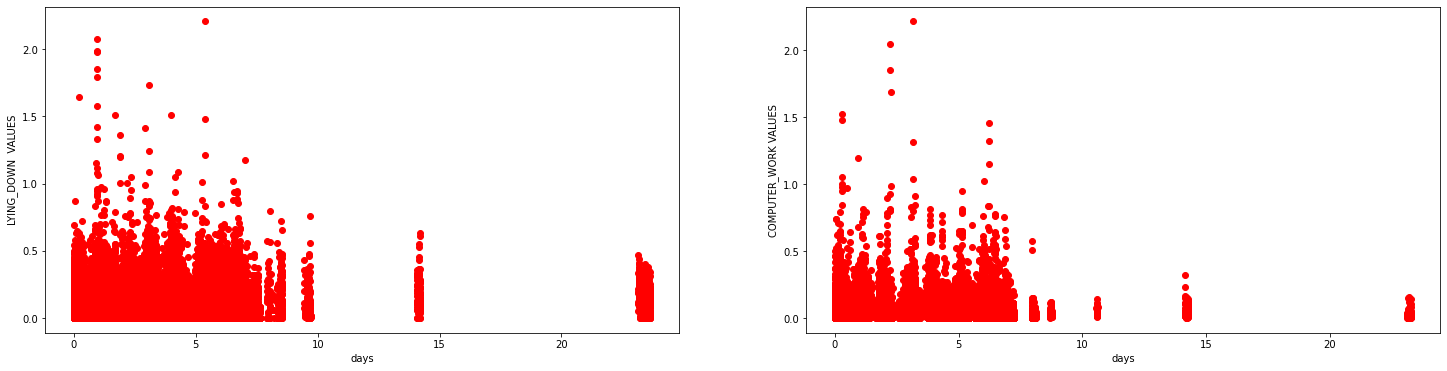

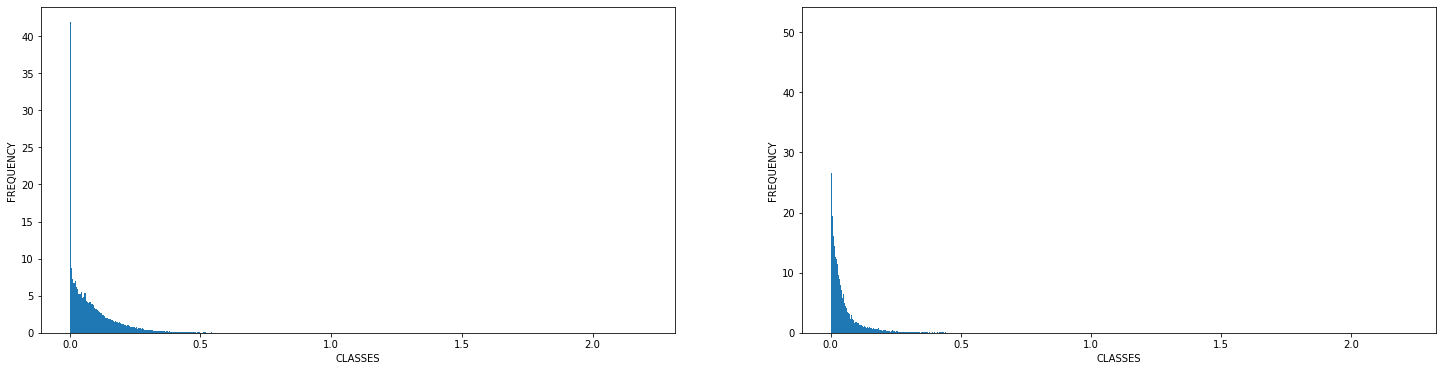

In [ ]:
#location:log_latitude_range : its index is 139
extract_data_and_graph_ALL(139)

The values appear to be higher for the COMPUTER_WORK activity.

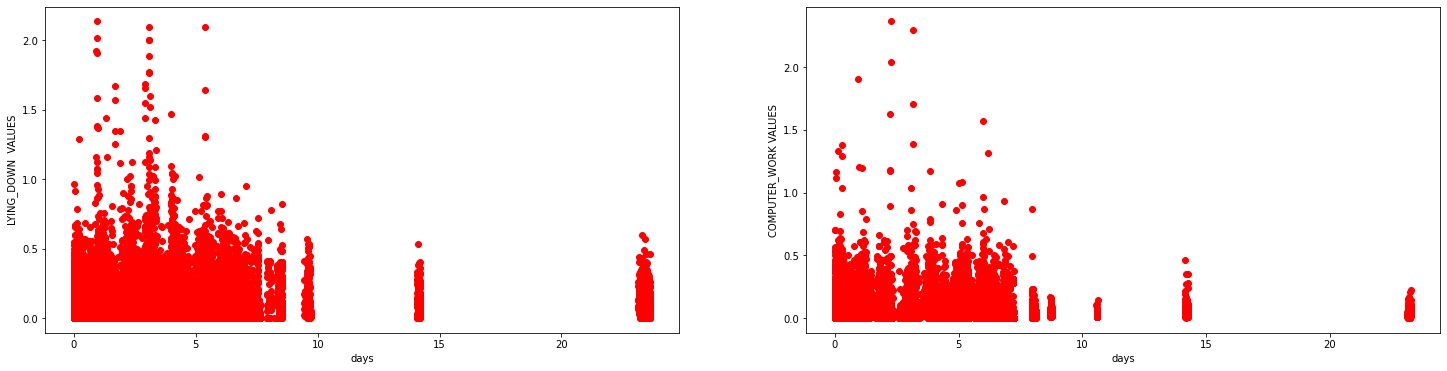

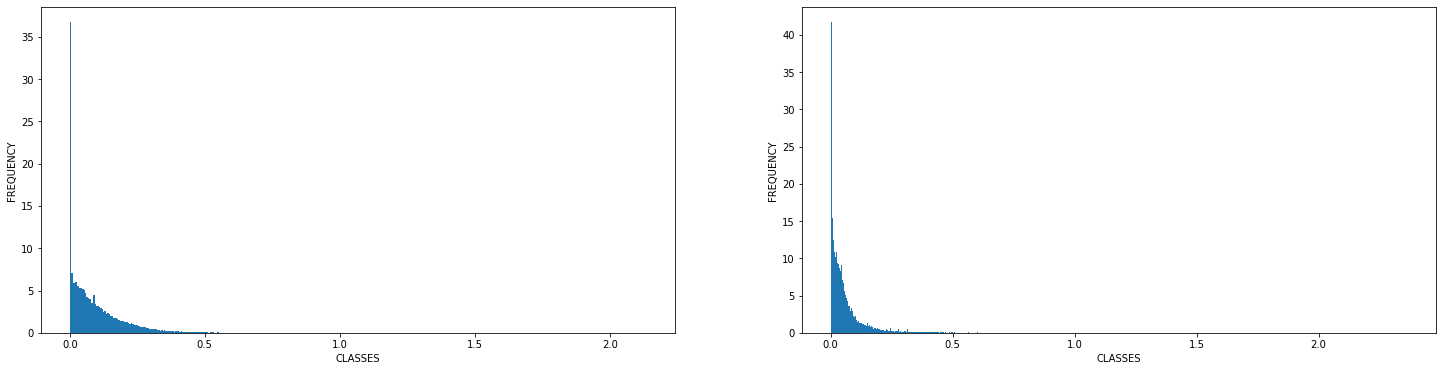

In [ ]:
##location:log_longitude_range : its index is 140
extract_data_and_graph_ALL(feature_index = 140)

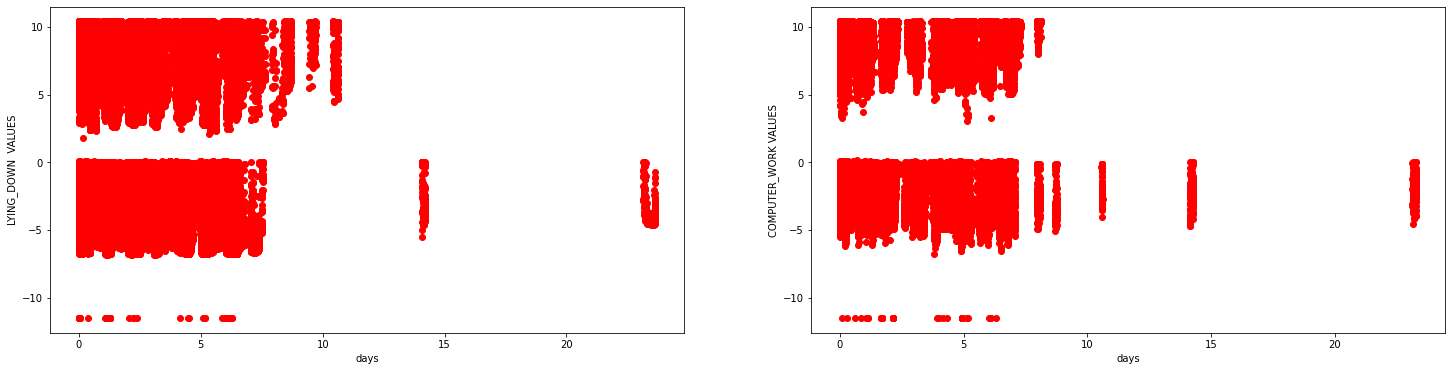

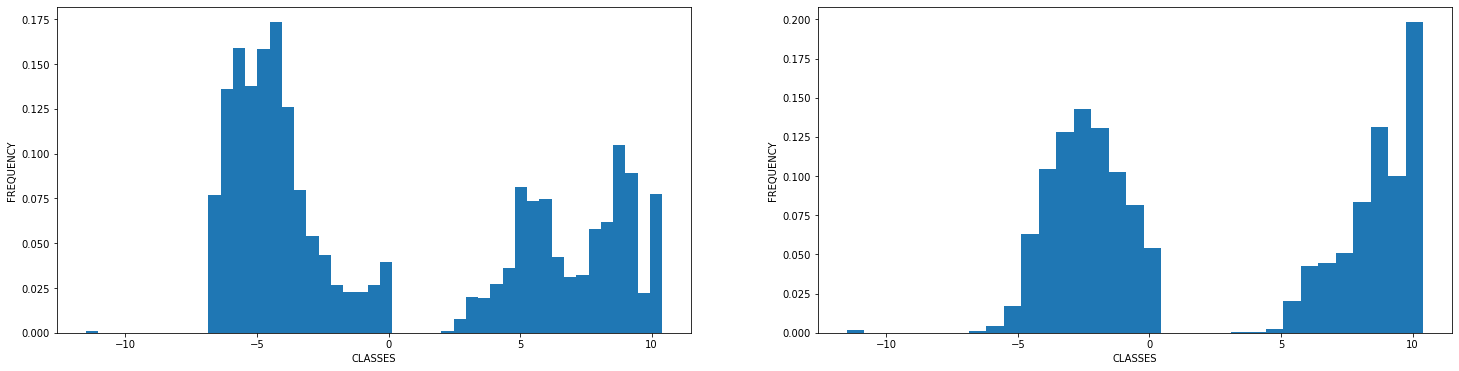

In [ ]:
# audio_properties:max_abs_value: its index is 181
extract_data_and_graph_ALL(feature_index = 181)

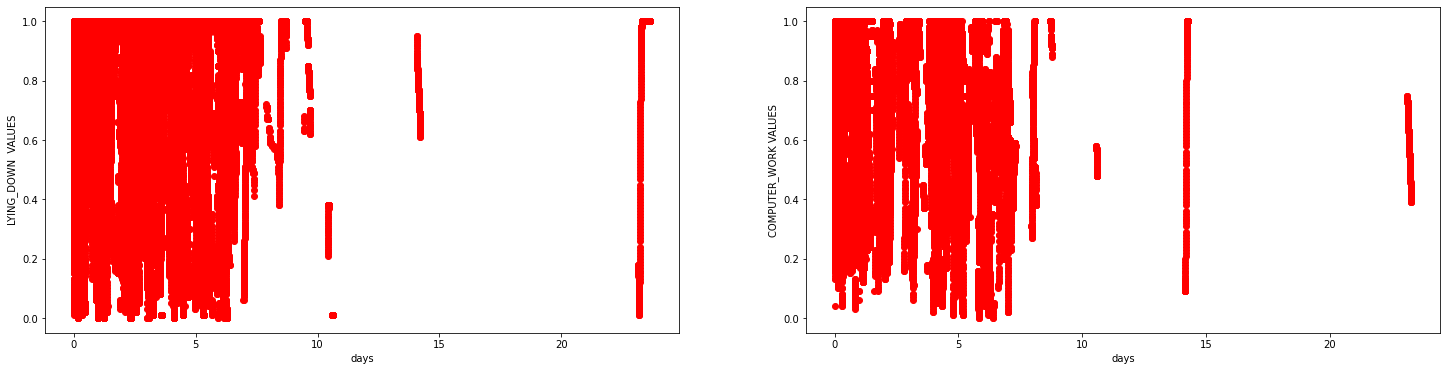

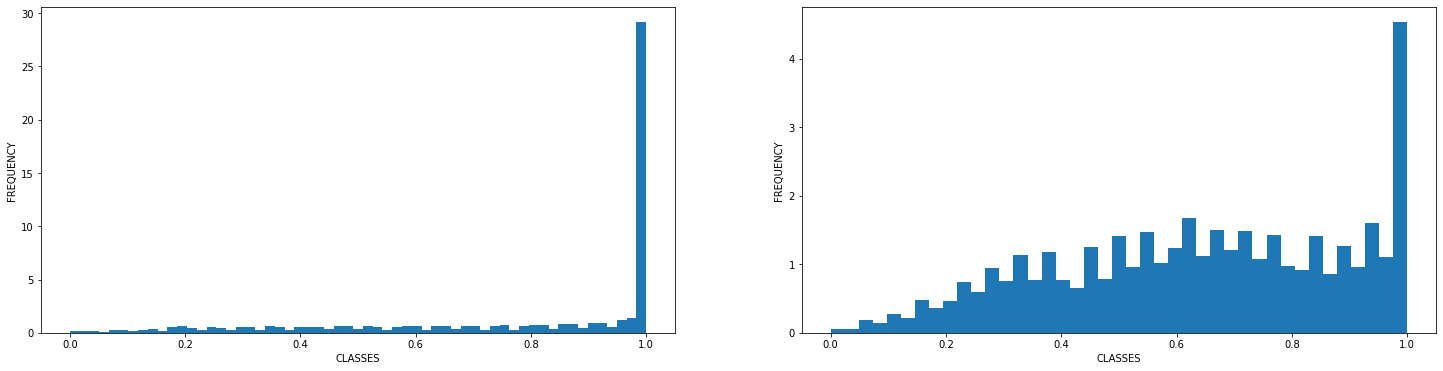

In [ ]:
# lf_measurements:battery_level: its index is 214
extract_data_and_graph_ALL(feature_index = 214)

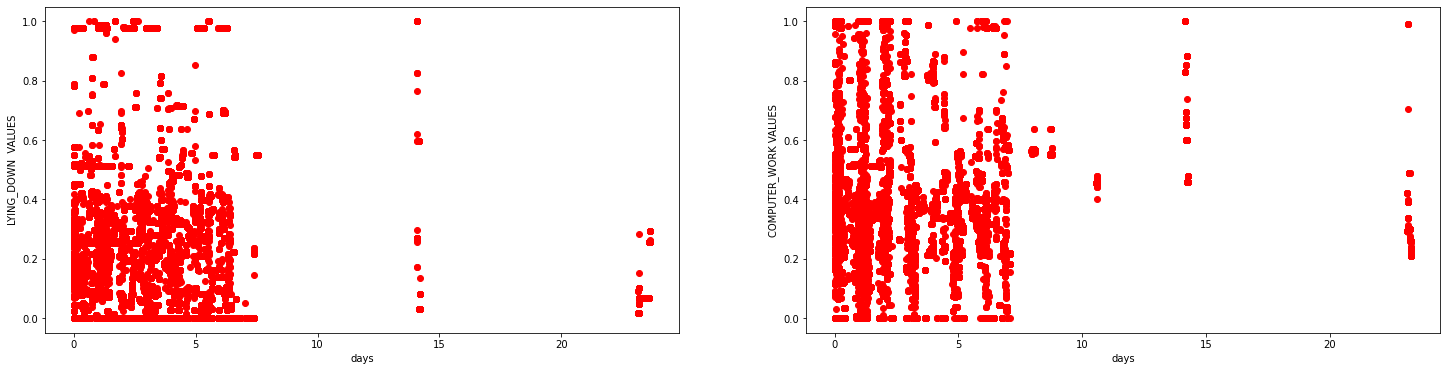

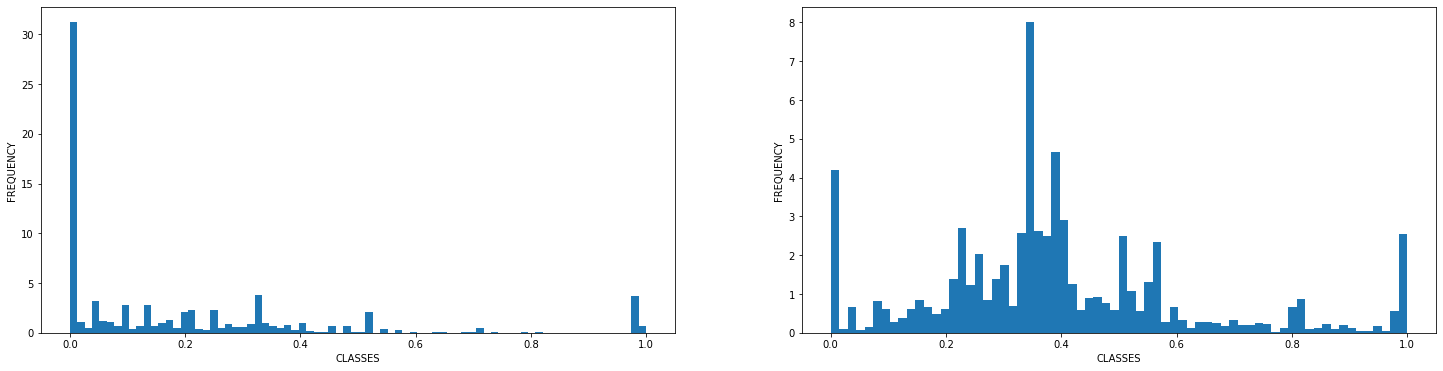

In [ ]:
# lf_measurements:screen_brightness: its index is 215
extract_data_and_graph_ALL(feature_index = 215)

## FINAL CONSIDERATION:


It seems that these plots confirmed what the plots related to the randomly chosen user said: the data are generally more numerous for the LYING_DOWN activities but higher in value for the COMPUTER_WORK activities.